This python script in Jupyter provides functions for converting between SO(3) and SU(2) matrices. Specifically, the novel contribution is the function get_su2 which determines the SU(2) matrix from a given SO(3).

Tested in python 3.8.8.

In [21]:
import sympy
from sympy.assumptions.refine import refine_Pow, refine_matrixelement
from sympy import symbols, simplify, refine, Q, Rational, Add, init_printing, trigsimp, factor
from sympy.functions.elementary.complexes import sign
from sympy.matrices import Matrix
import numpy as np
from IPython.display import display
import math

init_printing()

L1=np.array([[0, -1, 0],[1,0,0],[0,0,0]])
L2=np.array([[0, 0, 1],[0,0,0],[-1,0,0]])
L3=np.array([[0, 0, 0],[0,0,-1],[0,1,0]])
LIE_ALGEBRA={"l1": L1, "l2": L2, "l3": L3}
PHIP_CORR=np.array([[1,0,0],[0,-1,0],[0,0,1]])
PHIM_CORR=np.array([[-1,0,0],[0,1,0],[0,0,1]])
PSIP_CORR=np.array([[1,0,0],[0,1,0],[0,0,-1]])
PSIM_CORR=np.array([[-1,0,0],[0,-1,0],[0,0,-1]])
BELL_CORRS={"phip": PHIP_CORR, "phim": PHIM_CORR, 
            "psip": PSIP_CORR, "psim": PSIM_CORR}

def get_corr_mat(rho, pm):
    '''Gets the correlation matrix in pm basis.'''
    corr_mat=[]
    for p1 in pm:
        for p2 in pm:
            corr_mat.append(np.trace(np.kron(p1, p2).dot(rho)))
    return np.reshape(corr_mat, (3,3))

def get_su2(so3, separate_vals=False):
    '''gets su2 from so3. Requires Tr(so3)!=-1 (if it's not the answer
    will probably be wrong). separate_vals is used to keep simplification
    separate for the alpha_i and beta_j components. You likely want to
    keep this false when working with numbers. If you're working with
    variables, setting this to True may provide you with better
    simplification.
    so3: so3 matrix.
    separate_vales: bool'''
    so3=Matrix(so3)
    lie_algebra={k: Matrix(v) for k,v in LIE_ALGEBRA.items()}
    bell_corrs={k: Matrix(v) for k,v in BELL_CORRS.items()}
    alpha1=Rational(1/2)*sympy.sqrt(1-sympy.trace(so3 * bell_corrs["psim"]), False)
    alpha2=(Rational(1/2)*sign(sympy.trace(so3 * lie_algebra["l1"]))
        *sympy.sqrt(1-sympy.trace(so3 * bell_corrs["psip"]), False))
    beta1=(Rational(1/2)*sign(sympy.trace(so3 * lie_algebra["l2"]))
        *sympy.sqrt(1-sympy.trace(so3 * bell_corrs["phip"]), False))
    beta2=(Rational(1/2)*sign(sympy.trace(so3 * lie_algebra["l3"]))
        *sympy.sqrt(1-sympy.trace(so3 * bell_corrs["phim"]), False))
    if separate_vals:
        alpha1=simplify(alpha1, rational=True)
        alpha2=simplify(alpha2, rational=True)
        beta1=simplify(beta1, rational=True)
        beta2=simplify(beta2, rational=True)
    return Matrix([[Add(alpha1, 1j*alpha2, evaluate=False), 
                Add(beta1, 1j* beta2, evaluate=False)],
                [Add(-beta1, 1j* beta2, evaluate=False), 
                 Add(alpha1, -1j*alpha2, evaluate=False)]])

def get_su2_trminus1(so3, separate_vals=False):
    '''gets su2 from so3. Requires Trace(so3)=-1 (if it's not the answer
    will probably be wrong). Separate_vals is used to keep simplification
    separate for the alpha_i and beta_j components. You likely want to
    keep this false when working with numbers. If you're working with
    variables, setting this to True may provide you with better
    simplification.
    so3: so3 matrix.
    separate_vales: bool'''
    so3=Matrix(so3)
    g1=get_gamma(so3, LIE_ALGEBRA["l1"])
    g2=get_gamma(so3, LIE_ALGEBRA["l2"])
    g3=get_gamma(so3, LIE_ALGEBRA["l3"])
    I=sympy.eye(3)
    w0=get_W(so3, np.absolute(LIE_ALGEBRA["l1"]), 
          np.absolute(LIE_ALGEBRA["l2"]), np.absolute(LIE_ALGEBRA["l3"]))
    w1=get_W(so3, I, I, -np.absolute(LIE_ALGEBRA["l1"]))
    w2=get_W(so3, -np.absolute(LIE_ALGEBRA["l2"]), I, I)
    w3=get_W(so3, I, -np.absolute(LIE_ALGEBRA["l3"]), I)
    w4=get_W(so3, -I, -I, -I)
    if separate_vals:
        g1=refine(g1)
        g2=refine(g2)
        g3=refine(g3)
        w0=simplify(w0, rational=True)
        w1=simplify(w1, rational=True)
        w2=simplify(w2, rational=True)
        w3=simplify(w3, rational=True)
        w4=simplify(w4, rational=True)
    
    return (w0+(1-g1)*g2*g3*w1+g1*(1-g2)*g3*w2
            +g1*g2*(1-g3)*w3+g1*g2*g3*w4)

def get_so3(u,x,y,z):
    '''Gets so3 from su2.
    u: su2 matrix.
    x, y, z: pauli matrices.'''
    uconj=u.conjugate().T
    O=np.array([[1/2*np.trace(x.dot(u).dot(x).dot(uconj)), 1/2*np.trace(x.dot(u).dot(y).dot(uconj)), 
                 1/2*np.trace(x.dot(u).dot(z).dot(uconj))],
        [1/2*np.trace(y.dot(u).dot(x).dot(uconj)), 1/2*np.trace(y.dot(u).dot(y).dot(uconj)), 
         1/2*np.trace(y.dot(u).dot(z).dot(uconj))],
        [1/2*np.trace(z.dot(u).dot(x).dot(uconj)), 1/2*np.trace(z.dot(u).dot(y).dot(uconj)), 
         1/2*np.trace(z.dot(u).dot(z).dot(uconj))]])
    return O

def get_W(so3, x,y,z):
    '''Helper function. This is meant for the 
    case where trace(so3)=-1.
    x: matrix
    y: matrix
    z: matrix
    '''
    x=Matrix(x)
    y=Matrix(y)
    z=Matrix(z)
    bell_corrs={k: Matrix(v) for k,v in BELL_CORRS.items()}
    
    alpha2=(Rational(1/2)*sign(sympy.trace(so3 * x))
        *sympy.sqrt(1-sympy.trace(so3 * bell_corrs["psip"]), False))
    
    beta1=(Rational(1/2)*sign(sympy.trace(so3 * y))
        *sympy.sqrt(1-sympy.trace(so3 * bell_corrs["phip"]), False))
    
    beta2=(Rational(1/2)*sign(sympy.trace(so3 * z))
        *sympy.sqrt(1-sympy.trace(so3 * bell_corrs["phim"]), False))
    
    return Matrix([[1j*alpha2, beta1+1j* beta2],
                    [-beta1+1j* beta2, -1j*alpha2]])

def get_gamma(so3, l_i):
    '''Helper function. Returns the gamma value.'''
    so3=Matrix(so3)
    l_i=Matrix(l_i)
    if sympy.trace(so3 * np.absolute(l_i))==0:
        return 1
    else:
        return 1-sign(sympy.trace(so3*np.absolute(l_i)))**2

The rest of the script below are calculations from the paper.

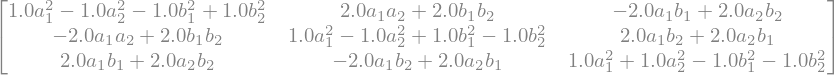

array([[ 1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

array([[-1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

array([[ 1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j]])

array([[-1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j]])

In [22]:
a1, a2, b1, b2=symbols('a1 a2 b1 b2', real=True)
phip=1/2*np.array([[1,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,1]])
phim=1/2*np.array([[1,0,0,-1],[0,0,0,0],[0,0,0,0],[-1,0,0,1]])
psip=1/2*np.array([[0,0,0,0],[0,1,1,0],[0,1,1,0],[0,0,0,0]])
psim=1/2*np.array([[0,0,0,0],[0,1,-1,0],[0,-1,1,0],[0,0,0,0]])

I=np.eye(2)
x=np.array([[0,1],[1,0]])
y=np.array([[0, -1j],[1j, 0]])
z=np.array([[1,0],[0,-1]])
paulis=[x, y, z]
phip_corr=get_corr_mat(phip, paulis)
phim_corr=get_corr_mat(phim, paulis)
psip_corr=get_corr_mat(psip, paulis)
psim_corr=get_corr_mat(psim, paulis)
bell_corrs={"phip": phip_corr, "phim": phim_corr, "psip": psip_corr, "psim": psim_corr}
u=a1*I+a2*1j*z+b2*1j*x+b1*1j*y
uconj=u.conjugate().T

O=np.array([[1/2*np.trace(x.dot(u).dot(x).dot(uconj)), 1/2*np.trace(x.dot(u).dot(y).dot(uconj)), 1/2*np.trace(x.dot(u).dot(z).dot(uconj))],
[1/2*np.trace(y.dot(u).dot(x).dot(uconj)), 1/2*np.trace(y.dot(u).dot(y).dot(uconj)), 1/2*np.trace(y.dot(u).dot(z).dot(uconj))],
[1/2*np.trace(z.dot(u).dot(x).dot(uconj)), 1/2*np.trace(z.dot(u).dot(y).dot(uconj)), 1/2*np.trace(z.dot(u).dot(z).dot(uconj))]])
display(simplify(O))
display(phip_corr)
display(phim_corr)
display(psip_corr)
display(psim_corr)

In [23]:
# print(simplify(1/2*np.trace(z.dot(u).dot(y).dot(uconj))))
# print(simplify(np.trace(O)))
display(simplify(np.trace(O.dot(L1))))
display(simplify(np.trace(O.dot(L2))))
display(simplify(np.trace(O.dot(L3))))
display(simplify(np.trace(O.dot(abs(L1)))))
display(simplify(np.trace(O.dot(abs(L2)))))
display(simplify(np.trace(O.dot(abs(L3)))))


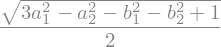

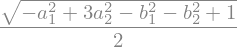

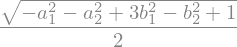

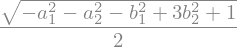

In [24]:
display(simplify(1+np.trace(O)))
display(simplify(Rational(1/2)*sympy.sqrt(1-sympy.trace(Matrix(O) * psim_corr)), rational=True))
display(simplify(Rational(1/2)*sympy.sqrt(1-np.trace(O.dot(psip_corr))), rational=True))
display(simplify(Rational(1/2)*sympy.sqrt(1-np.trace(O.dot(phip_corr))), rational=True))
display(simplify(Rational(1/2)*sympy.sqrt(1-np.trace(O.dot(phim_corr))), rational=True))
display(simplify(np.trace(O.dot(psim_corr))))
display(simplify(np.trace(O.dot(psip_corr))))
display(simplify(np.trace(O.dot(phip_corr))))
display(simplify(np.trace(O.dot(phim_corr))))

In [25]:
rho_ab=1/4*np.array([[1,-1,1J,1J],[-1,1,-1J,-1J],
    [-1J, 1J, 1, 1],[-1J, 1J, 1, 1]])
rhoab_corr=get_corr_mat(rho_ab, paulis)
L=np.array([[0,0,1],[1,0,0],[0,1,0]])
E=np.array([[1,0,0],[0,-1,0],[0,0,1]])
R=np.array([[0,0,-1],[1,0,0],[0,-1,0]])
# left_so3, diag_corr, right_so3=np.linalg.svd(rhoab_corr)
# display(L @ L.T)
# display(R @ R.T)
# display(rhoab_corr)
# display(L @ E @ R)

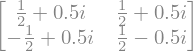

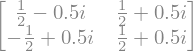

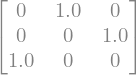

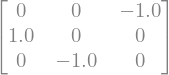

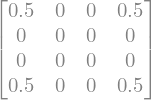

array([[ 1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

In [26]:
leftsu2=get_su2(L.T)
rightsu2=get_su2(R)
display(leftsu2)
display(rightsu2)
display(simplify(get_so3(leftsu2, x,y,z), rational=True))
display(simplify(get_so3(rightsu2, x,y,z), rational=True))
display(simplify(np.kron(leftsu2, rightsu2) @ rho_ab 
        @ np.kron(leftsu2,rightsu2).conjugate().T, rational=True))
display(phip_corr)

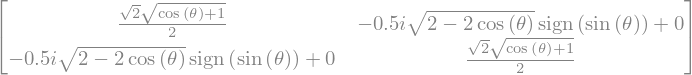

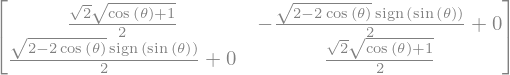

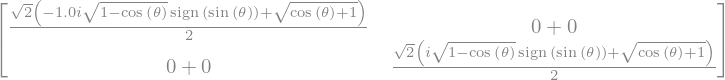

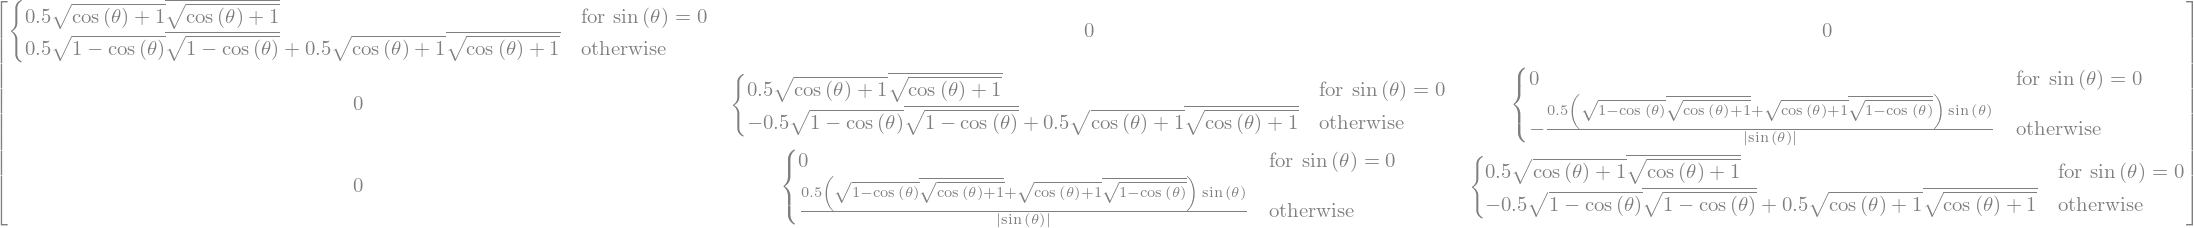

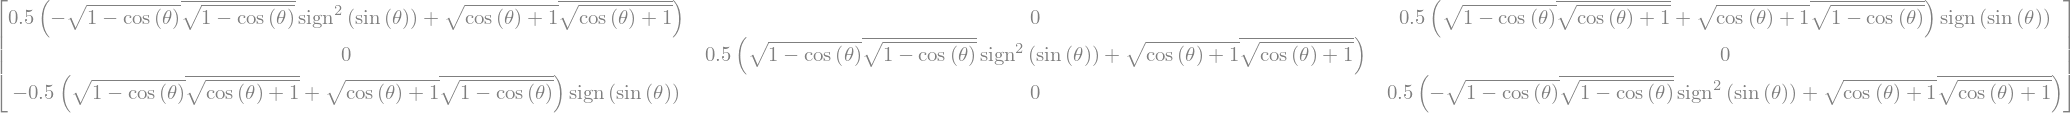

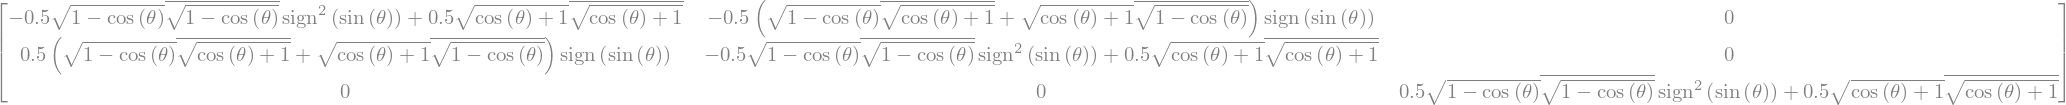

In [27]:
theta=symbols('theta', real=True)
xso3=np.array([[1,0,0],[0, sympy.cos(theta), -sympy.sin(theta)],
              [0, sympy.sin(theta), sympy.cos(theta)]])
yso3=np.array([[sympy.cos(theta), 0, sympy.sin(theta)],[0, 1, 0],
              [-sympy.sin(theta), 0, sympy.cos(theta)]])
zso3=np.array([[sympy.cos(theta), -sympy.sin(theta), 0],
               [sympy.sin(theta), sympy.cos(theta), 0],
              [0, 0, 1]])
xsu2=trigsimp(get_su2(xso3))
ysu2=trigsimp(get_su2(yso3))
zsu2=trigsimp(get_su2(zso3))
display(xsu2)
display(ysu2)
display(zsu2)
display(trigsimp(simplify(get_so3(xsu2, x, y,z))))
display(trigsimp(get_so3(ysu2, x, y,z)))
display(trigsimp(get_so3(zsu2, x, y,z)))

The following calculations check the appendix.

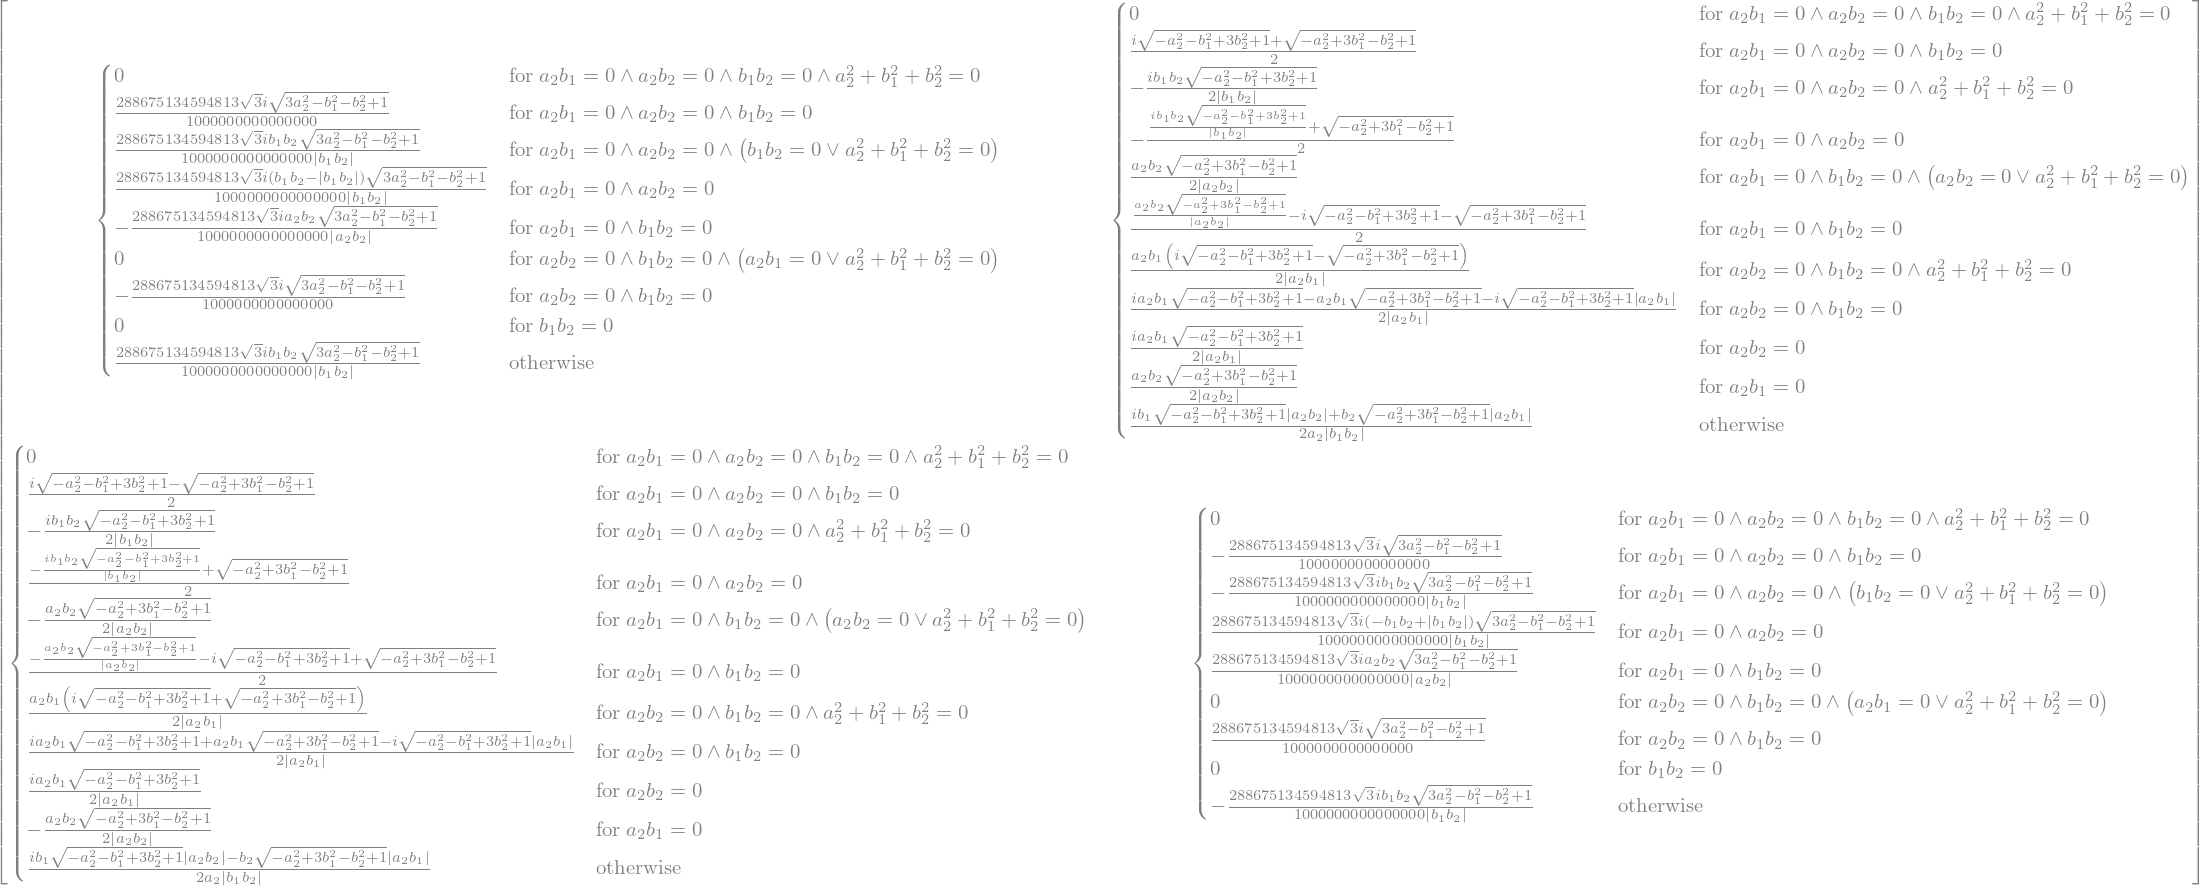

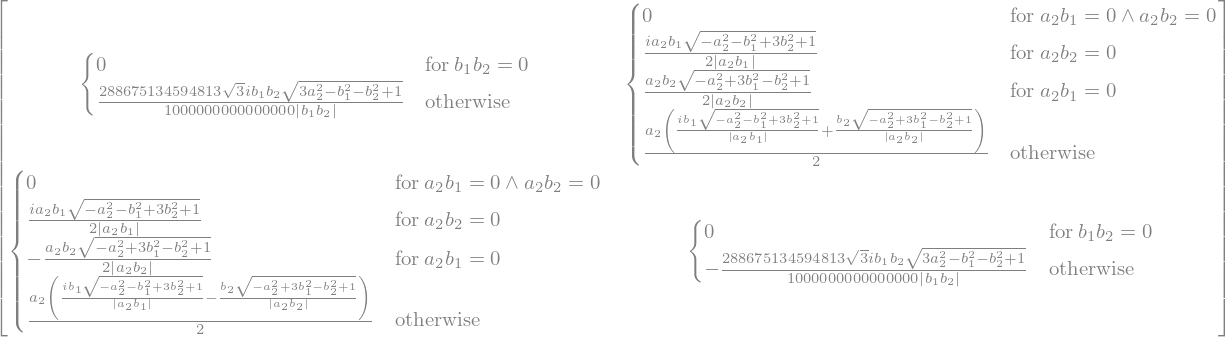

In [28]:
#case1:
# display(simplify(refine(get_su2_trminus1(Matrix(O).subs({a1:0}), lie_algebra, bell_corrs, separate_vals=False),
#               Q.nonzero(a2) & Q.nonzero(b1) & Q.nonzero(b2)), rational=True))
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0}), 
                  separate_vals=True),rational=True))
display(simplify(get_W(Matrix(O).subs({a1:0}), np.absolute(LIE_ALGEBRA['l1']), 
      np.absolute(LIE_ALGEBRA['l2']), 
       np.absolute(LIE_ALGEBRA['l3'])), rational=True))

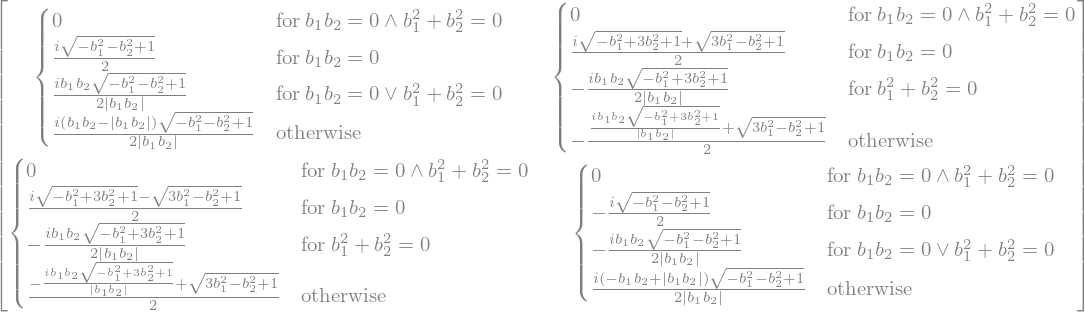

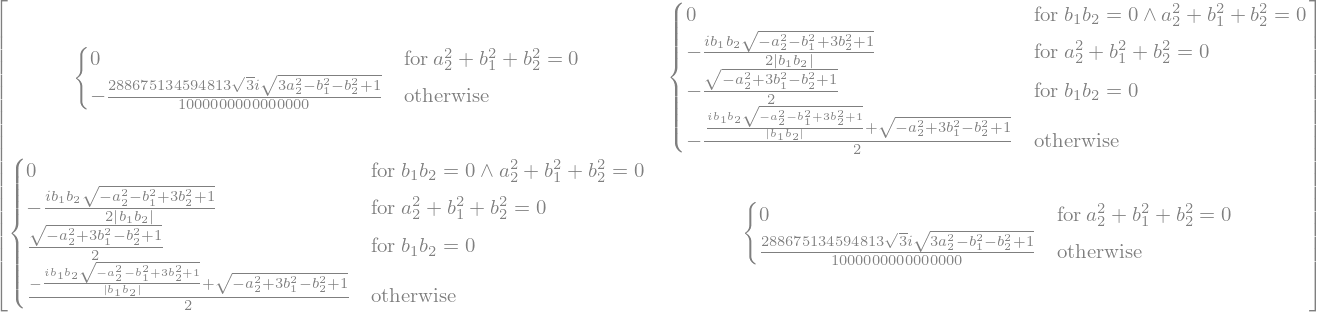

In [29]:
#case2:
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0, a2:0}), 
            separate_vals=True),rational=True))
I=sympy.eye(3)
display(simplify(get_W(Matrix(O).subs({a1:0}), I, 
      I, -np.absolute(LIE_ALGEBRA['l1'])), rational=True))

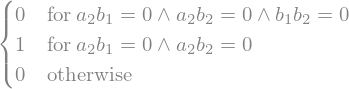

In [30]:
#(1-g1)*g2*g3:
g1=get_gamma(Matrix(O).subs({a1:0}), LIE_ALGEBRA["l1"])
g2=get_gamma(Matrix(O).subs({a1:0}), LIE_ALGEBRA["l2"])
g3=get_gamma(Matrix(O).subs({a1:0}), LIE_ALGEBRA["l3"])
display(factor((1-g1)*g2*g3))
display(simplify((1-g1)*g2*g3))

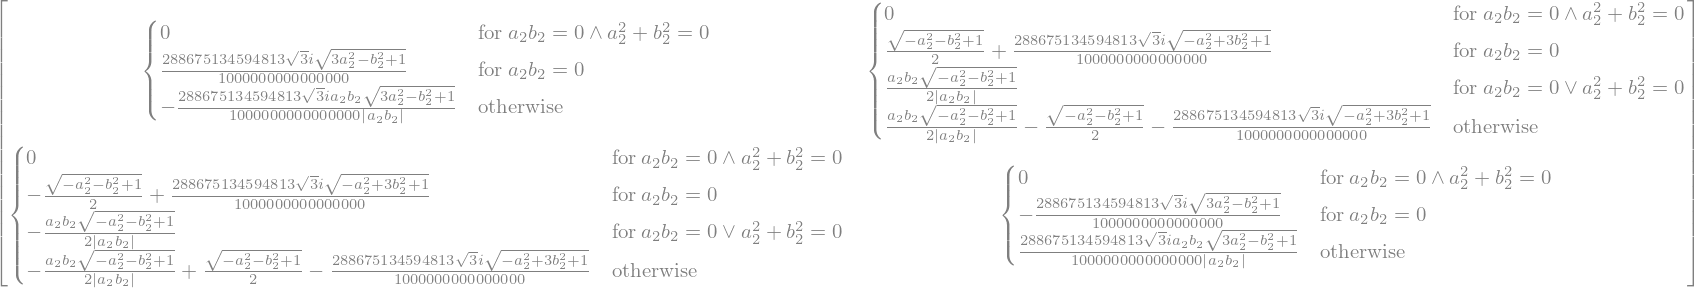

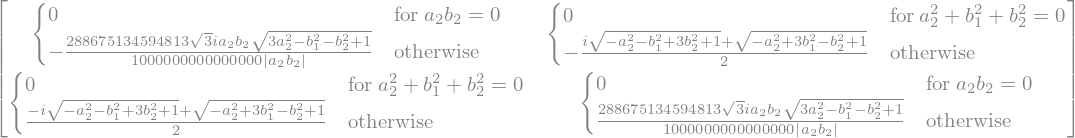

In [31]:
#case 3:
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0, b1:0}), 
              separate_vals=True),rational=True))
display(simplify(get_W(Matrix(O).subs({a1:0}), 
      -np.absolute(LIE_ALGEBRA['l2']), I, I), rational=True))

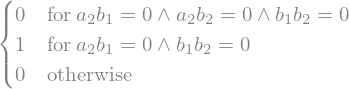

In [32]:
#g1*(1-g2)*g3:
display(factor(g1*(1-g2)*g3))
display(simplify(g1*(1-g2)*g3))

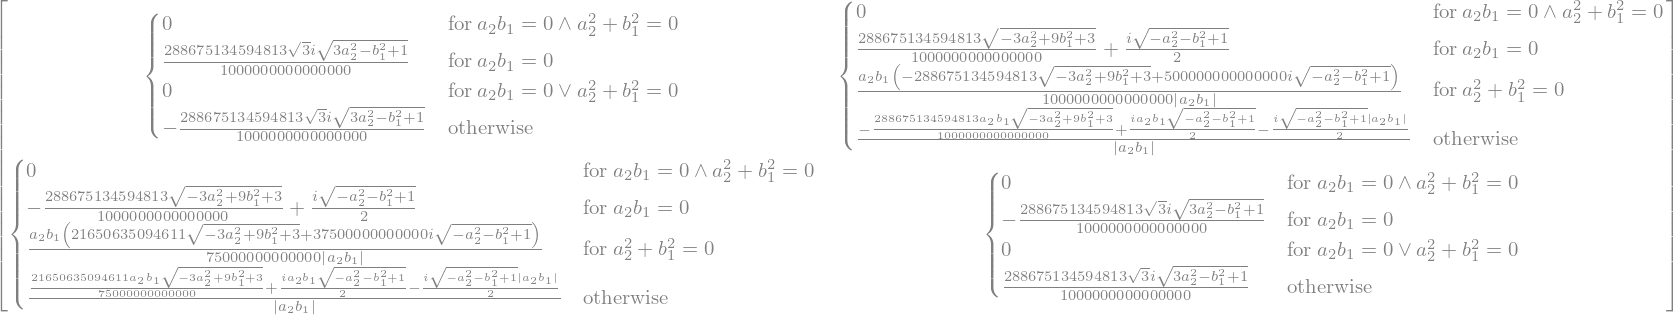

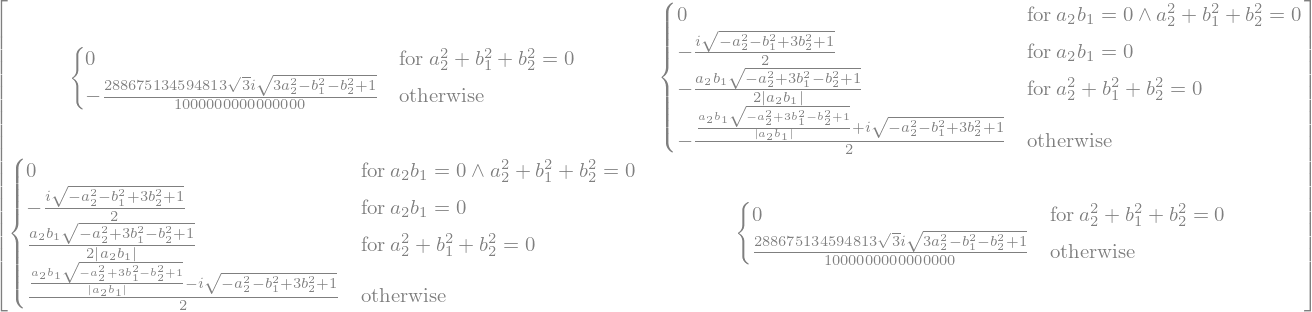

In [33]:
#case 4:
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0, b2:0}), 
              separate_vals=True),rational=True))
display(simplify(get_W(Matrix(O).subs({a1:0}), 
      I,-np.absolute(LIE_ALGEBRA['l3']), I), rational=True))

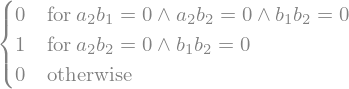

In [34]:
#g1*g2*(1-g3):
display(factor(g1*g2*(1-g3)))
display(simplify(g1*g2*(1-g3)))

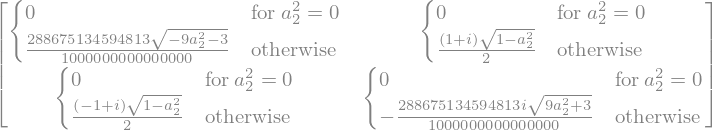

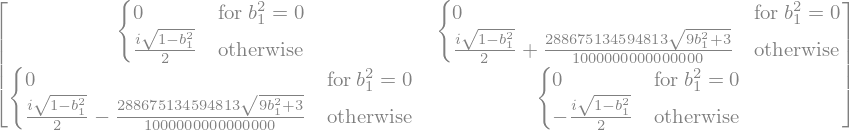

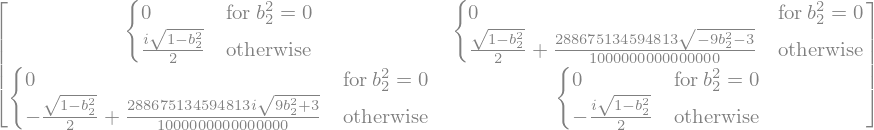

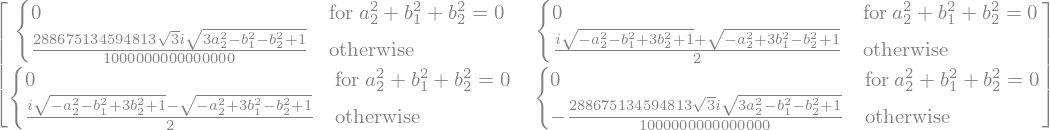

In [35]:
#case 5,6,7:
# display(simplify(refine(get_su2_trminus1(Matrix(O).subs({a1:0}), lie_algebra, bell_corrs, separate_vals=False),
#               Q.nonzero(a2) & Q.nonzero(b1) & Q.nonzero(b2)), rational=True))
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0, b1:0, b2:0}), 
              separate_vals=True),rational=True))
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0, a2:0, b2:0}), 
              separate_vals=True),rational=True))
display(simplify(get_su2_trminus1(Matrix(O).subs({a1:0, b1:0, a2:0}), 
              separate_vals=True),rational=True))
display(simplify(get_W(Matrix(O).subs({a1:0}), 
      -I,-I, -I), rational=True))


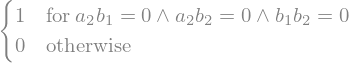

In [36]:
#g1*g2*g3:
display(factor(g1*g2*g3))
display(simplify(g1*g2*g3))